LeNet（LeNet-5）由两个部分组成： 卷积编码器和全连接层密集块

In [2]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28) # [B, C, H, W]

# LeNet的实现：
net = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(), # Flatten()就是第一维的批量不变，后面的拉成一个向量
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))


检查模型：打印看看各个维度的变化

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net: # nn.Sequential实现，因此可以迭代出每一层
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


LeNet在Fashion-MNIST数据集上的表现

In [4]:
batch_size = 2 # 批量大小
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

对evaluate_accuracy函数进行轻微的修改

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 打开测试模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X] # 将样本送入gpu
        else:
            X = X.to(device)
        y = y.to(device) # 将标签送入gpu
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

为了使用 GPU，我们还需要一点小改动

In [6]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m): # 定义了初始化模型的函数
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights) # run初始化模型的参数
    print('training on', device)
    net.to(device) # 将模型送入gpu
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) # 优化器
    loss = nn.CrossEntropyLoss() # 交叉熵损失函数
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], # 可视化
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs): # 轮次
        metric = d2l.Accumulator(3)
        net.train() # 打开训练模式
        for i, (X, y) in enumerate(train_iter): # 迭代批次
            timer.start() # 记录开始训练时间
            optimizer.zero_grad() # 梯度清零
            X, y = X.to(device), y.to(device) # 特征数据和标签送入gpu
            y_hat = net(X) # 数据送入网络，得出预测结果
            l = loss(y_hat, y) # 预测值 与 真实值计算出 损失
            l.backward() # 反向传播，求出梯度
            optimizer.step() # 更新梯度
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0]) # 计算
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

训练和评估LeNet-5模型

loss 0.455, train acc 0.836, test acc 0.831
1261.2 examples/sec on cuda:0


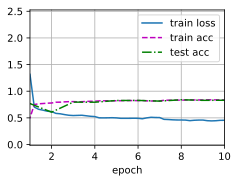

In [7]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())